## Predicting Programming Languages
### Natural Language Processing Among GitHub Repositories
By: _AJ Martinez,        
Ben Smith,        
Nicholas Dougherty_          

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import re
import nltk

# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# import modules 
from prepare import * 
import model
import acquire 
import explore 
#import model 

# imports for NLP extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

Reading from local CSV...


***
## Overview and Goals

The goal of this project is to determine the main coding language of a project based on the contents of its README using NLP methods. We acquired data from trending pages on GitHub. In order to recreate this project you will need to access the json of the data we acquired, specifically "data1.json".

A total of 109 repositories were scraped initially. We filtered for JavaScript, HTML and Python, with other languages categorized as 'Other'. 

## Findings

We found that a () model using Lemmatized data performed the highest with an accuracy of () on the validate data set. With a final test accuracy of (). This outperformed our baseline accuracy of (). Our model was (list results and whatnot.)

### With More Time

We'd like to acquire more data to see if we can improve the results for distinguishing among (). Our sample size was fairly small during this project.
*** 
***
## Acquisition and Preparation

Data was obtained through functions that scraped repository collections on GitHub. First we manually explored GitHub using Chrome to inspect the HTML elements; the requests module obtained the HTML as a list of Universal Resource Locator (URL) endpoints, which were garnered from the trending portal and then appended to the origin. BeautifulSoup was essential in this regard. We scripted the process of requesting other pages, obtaining the README data form those as well through over a hundred repositories.       
Here is a segment of the code used, the full code  can be viewed in the acquire.py script elsewhere in our repository. 

```
# create an empty list to store endpoints
    endpoints = []
    # go to each url - trending repos daily, weekly, and monthly
    for url in ['https://github.com/trending?since=daily&spoken_language_code=en',
                'https://github.com/trending?since=weekly&spoken_language_code=en',
                'https://github.com/trending?since=monthly&spoken_language_code=en']:
        # get the response
        response = get(url)
        # create the beautiful soup object; It creates a parse tree from page source code
        soup = BeautifulSoup(response.text, 'html.parser')
        # identify html objects containing each repository
        for repo in soup.select('.Box-row'):
            # pull out the url endpoint for that repo and append to the list
            endpoints.append(repo
                             .select_one('h1')
                             .select_one('a')
                             .attrs['href'])
```
The assimilated data was stored in a .json file, which was then used to obtain our Dataframe, like so:

In [5]:
# Read in data from the JSON created through acquire
df = pd.read_json('data1.json')
# View the content of the first row 
df.head(1)

repo language  \
0  google/googletest      C++   

                                     readme_contents  
0  # GoogleTest\n\n### Announcements\n\n#### Live...

From here, we break our data down into smaller component via parsing tools from the nltk packaged library. 
- All text was converted to lowercase for the sake of normalcy
- Removed:
    - accented, non-ASCII characters
    - special characters
    - stopwords
- Words were stemmed and lemmatized as well. 

All of these processes were combined into a single function:

In [6]:
# prepare the dataframe and return text stemmed, lemmatized, cleaned, tokenized, et cetera
df = prep_repos(df)
# This gives us the following. 
# Original content in one column; a clean column; another that is stemmed; lemmatized; and the languages
df.head(2)

repo language  \
0                  google/googletest      C++   
1  projectdiscovery/nuclei-templates   Python   

                                            original  \
0  # GoogleTest\n\n### Announcements\n\n#### Live...   
1  \n\n<h1 align="center">\nNuclei Templates\n</h...   

                                               clean  \
0  googletest announcements live head googletest ...   
1  h1 aligncenter nuclei templates h1 h4 aligncen...   

                                             stemmed  \
0  googletest announc live head googletest follow...   
1  h1 aligncent nuclei templat h1 h4 aligncenterc...   

                                          lemmatized language_reduced  
0  googletest announcement live head googletest f...            Other  
1  h1 aligncenter nucleus template h1 h4 aligncen...           Python

Additionally, as mentioned earlier in the overview, we filtered languages so that anything that was not JavaScript, HTML or Python was bucketed as 'Other'.
```
df['language_reduced'] = df.language.apply(lambda lang: lang if lang in ['JavaScript', 'HTML', 'Python'] else 'Other')
```
The counts are as follows:

In [4]:
df.language_reduced.value_counts(normalize=True)

Other         0.623656
JavaScript    0.150538
Python        0.139785
HTML          0.086022
Name: language_reduced, dtype: float64

While in the preparatory stage, we discovered that some languages were listed as None. Additionally, some rows had nothing other than '' as their body. These were removed using
```
df['original'] = df['original'].apply(lambda text: np.nan if text == '' else text)
df = df.dropna()
```
And 

In [5]:
df['original'] = df['original'].apply(lambda text: np.nan if text == '' else text)

## Exploratory Data Analysis

With prepared dsta we can start exploring. Our goal is to try to identify the language for the repo based on words or README length.

In this visualizations we aim to answer questions like:

- What are the top 3 languages?
- What are the top 25 words?
- What are the top 10 words for each language?
- What language has the longest messages?

### Top languages

In [6]:
df['language'].value_counts().head(3)

JavaScript    14
Python        13
TypeScript     9
Name: language, dtype: int64

### Top 25 Words

In [7]:
word_counts = explore.words_to_counts(df)
# set up some basic matplotlib style parameters
plt.rc('figure', figsize=(17, 10))
plt.style.use('seaborn-darkgrid')
plt.rc('font', size=18)

Text(0.5, 1.0, 'Top 25 Most Frequent Words')

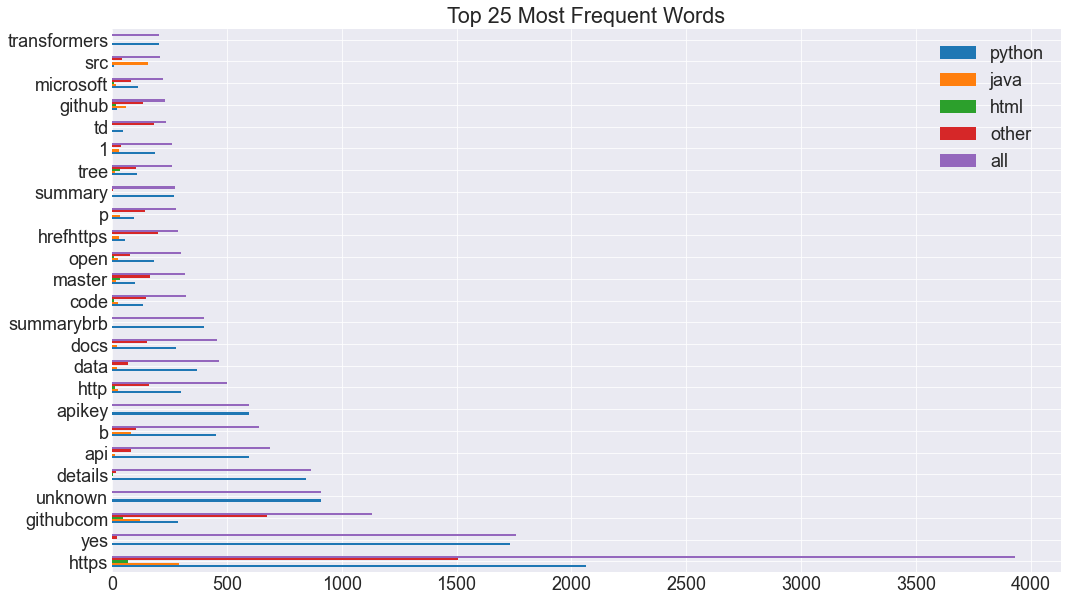

In [8]:
word_counts.sort_values('all', ascending=False).head(25).plot.barh()
plt.title('Top 25 Most Frequent Words')

### Top 10 words for most common languages

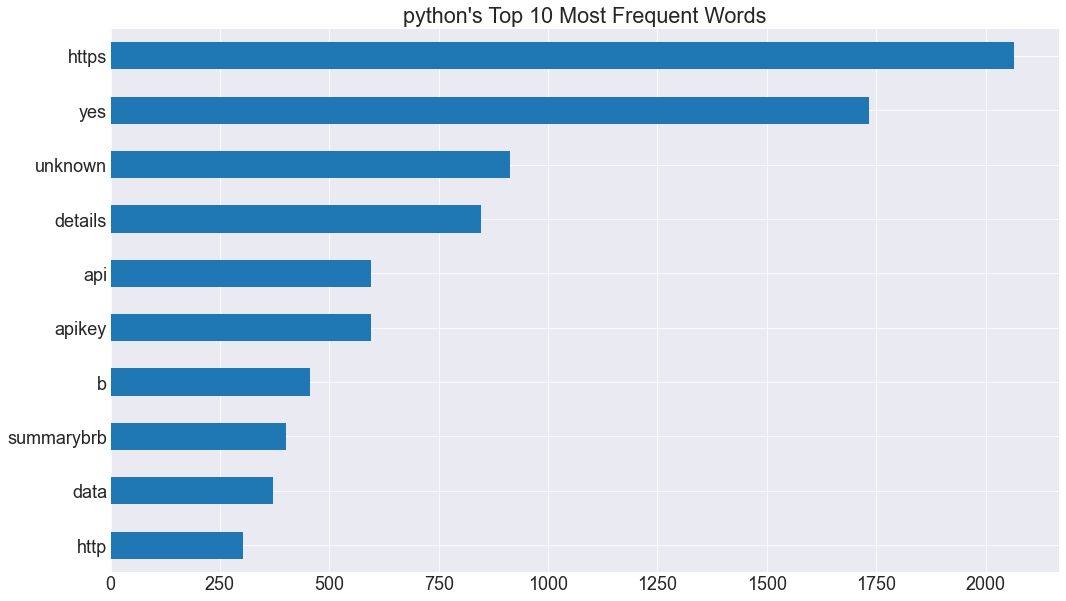

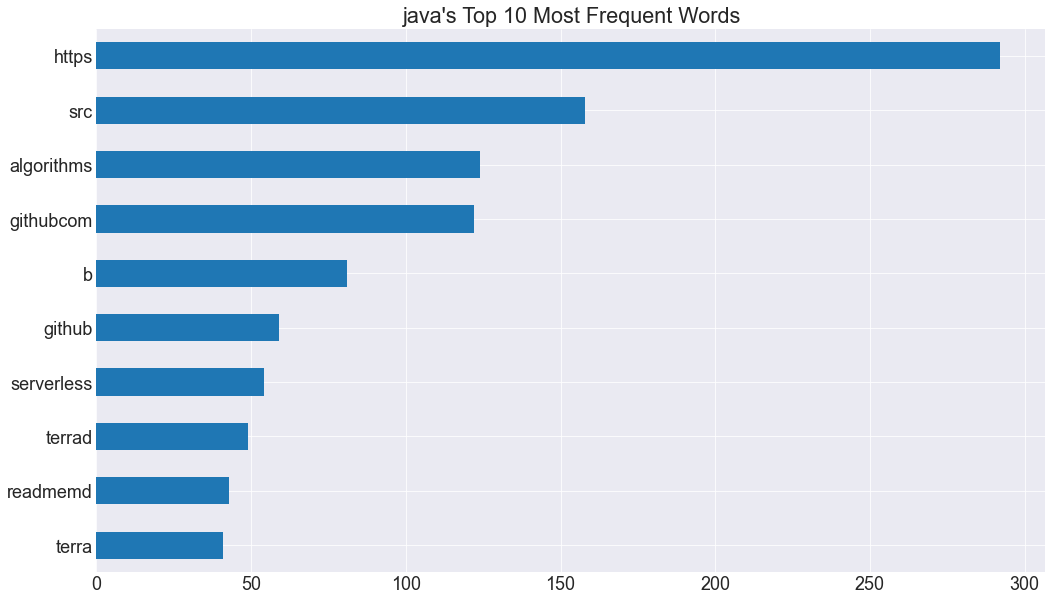

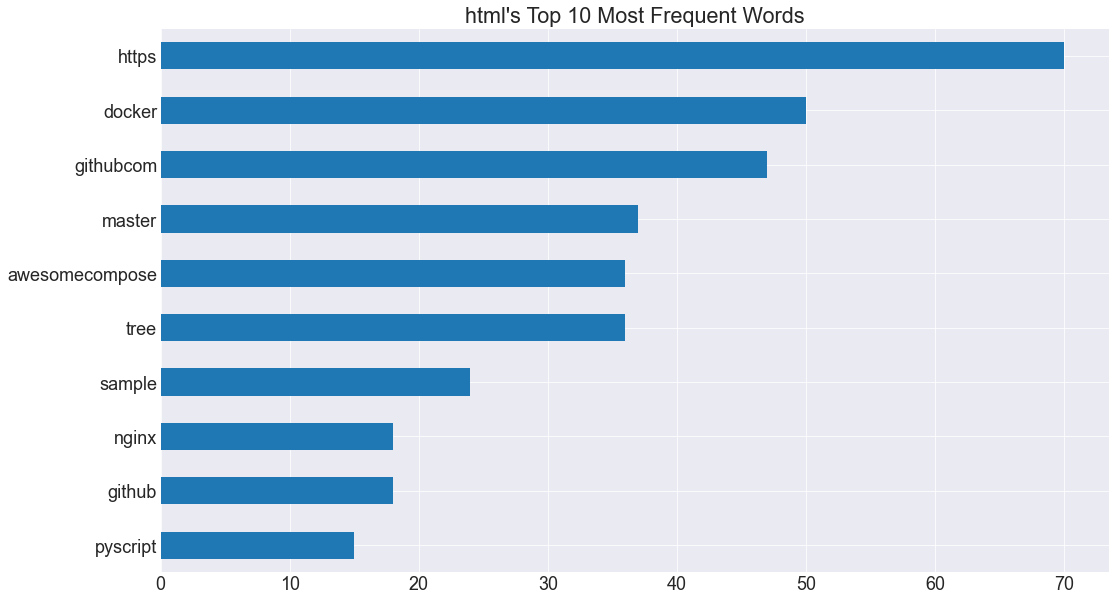

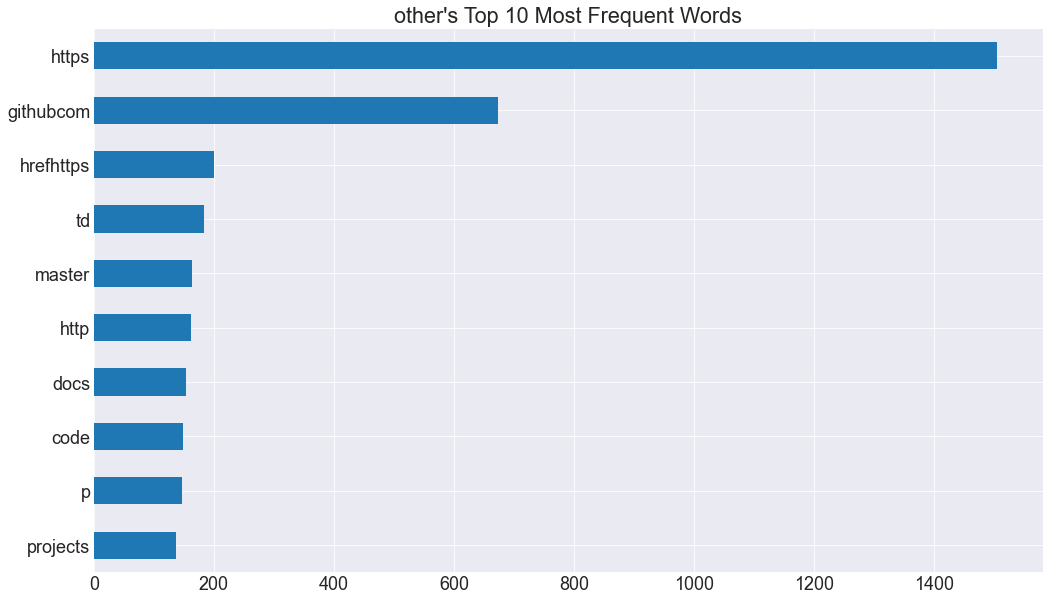

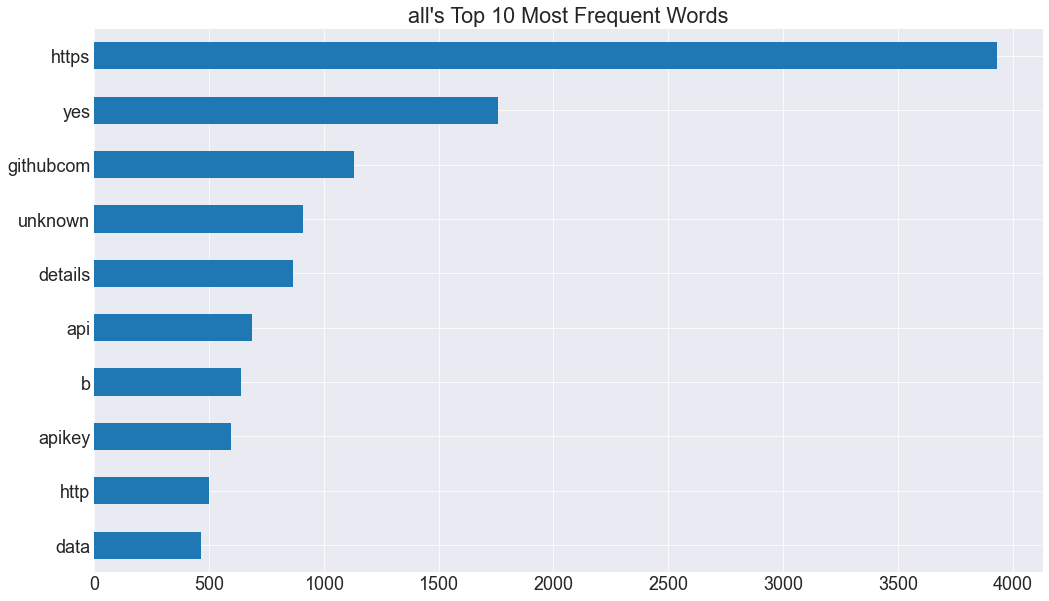

In [9]:
for col in word_counts.columns:
    barh = word_counts.sort_values([col]).tail(10)
    barh[col].head(10).plot.barh()
    plt.title(f'{col}\'s Top 10 Most Frequent Words')
    plt.show()

### Longest message

In [11]:
explore.longest_readme(df)

Top 20 Longest Message


,language_reduced,message_length,word_count
88,Python,143302,18334
10,Python,44832,5437
86,Python,35082,3625
57,Python,31184,4099
74,Other,20355,2781
17,Python,19839,2428
41,Other,19196,1870
73,Other,16006,1344
46,Other,12062,1473
13,JavaScript,11647,1423


In [12]:
explore.longest_msg_avg(df)

Average Longest Message by Language


,message_length,word_count
language,,
Python,23424.62,2884.08
Assembly,20355.00,2781.00
PHP,12062.00,1473.00
Swift,9699.00,1157.00
TypeScript,7448.33,741.67
V,7377.00,975.00
Java,6520.67,727.33
Go,6291.60,786.40
Jupyter Notebook,6000.75,720.75


Takeaways:
- a lot of languages, consider reducing them
- https is the most common word in all languages
- Python has the longest average readme

## Modeling

In [ ]:
target = 'language_reduced'

##### Split the Data
Create three separate samples to avoid data leakage while fitting and evaluating machine learning models.      
Afterwards, initialize the infrastructure for storing information about our models' performance. 

In [7]:
# split the data using sklearn's train_test_split inside the split_data function
train, validate, test = split_data(df, target)

train	 n = 51
validate n = 23
test	 n = 19


In [8]:
# initialize the model_number variable at 0
model_number = 0 
# initialize an empty dataframe
model_results = pd.DataFrame()

#### Baseline
Here, we establish baseline predictions based on the most frequently ocurring target class and evaluate the baseline accuracy.

In [9]:
model_number, model_results = model.run_baseline(train[target], model_number, model_results)

### Machine Learning Classsifiers

Here, we create, fit and evaluate the following types of machine learning classification models, using our train and validate samples. 

- Decision Tree
- Random Forest
- Multinomial Naive Bayes
- Complement Naive Bayes

Each model is run using two types of feature preprocessing:

- Term Frequency - Inverse Document Frequency (TF/IDF) Vectorization
- Count Vectorization (CV) AKA "Bag of Words"

For each type of model and type of preprocessing, the other associated hyperparameters were also varied, creating a total of 68 unique models with varying performance.

In [10]:
# user defined functions which create sklearn models with varying features and hyperparameters and store
# information about the models and their performance
model_number, model_results = model.run_decision_tree(train, validate, target, model_number, model_results)
model_number, model_results = model.run_random_forest(train, validate, target, model_number, model_results)
model_number, model_results = model.run_naive_bayes(train, validate, target, model_number, model_results)

#### Results
Below the resulting accuracy scores on both train and validate per model. 

In [11]:
model.display(model_results)

model_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,baseline
sample_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
train,0.862745,0.803922,0.921569,0.862745,0.960784,0.941176,1.000000,0.980392,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.647059,0.647059,0.627451,0.627451,0.627451,0.627451,0.627451,0.627451,0.666667,0.647059,0.627451,0.627451,0.627451,0.627451,0.627451,0.627451,0.666667,0.647059,0.627451,0.627451,0.627451,0.627451,0.627451,0.627451,0.666667,0.647059,0.627451,0.627451,0.627451,0.627451,0.627451,0.627451,0.960784,0.980392,1.000000,0.960784,0.627451,0.941176,0.980392,0.941176,0.627451,0.921569,0.921569,0.941176,0.627451,0.862745,0.921569,0.941176,0.627451,0.843137,0.921569,0.941176,0.627451
validate,0.434783,0.652174,0.434783,0.608696,0.434783,0.608696,0.434783,0.608696,0.434783,0.608696,0.434783,0.608696,0.434783,0.608696,0.434783,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,0.608696,NaN


### Best Model

Here, we choose the model which performed with the highest level of accuracy on the validate sample. We choose accuracy as our evaluation metric because in this multi-class classifier, we have no reason to favor any one of the target classes over any other.

In [12]:
# obtain the model numbers with the highest accuracy on validate
best = model.get_best(model_results)
# display info about those models
model_results[model_results.model_number.isin(best)]

,model_number,model_type,sample_type,accuracy,feature_type,max_depth,min_samples_leaf,alpha
3,2,decision_tree,train,0.803922,CV/BOW,3.0,NaN,NaN
4,2,decision_tree,validate,0.652174,CV/BOW,3.0,NaN,NaN


Model # 2 achieves the highest validate score of 65%, though this is actually 1 point below our baseline accuracy.

### Final Test

Here, we recreate model #2 and evaluate it on our test sample, which approximates how it might perform when used on additional READMEs which were not included in our samples.

In [13]:
model.test_model_2(train, test, target)

0.631578947368421

We see another small reduction in performance to 63%, making it about 3% below the baseline of 66%--and not particularly useful. 